# Generate  simulations of a SED including atmospheric effect and detector effect


- Author : Sylvie Dagoret-Campagne
- Date of creation :  July 4th 2016


- Original SED can be found here :

ftp://ftp.stsci.edu/cdbs/current_calspec/



In [1]:
import numpy as np

%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from astropy.io import fits

In [3]:
import os

In [4]:
from scipy.interpolate import UnivariateSpline

## Calspec SED

In [5]:
path_sed='calspec'
basefile_sed='hd158485_stis_003.fits'
obj_name='hd158485'
night_name='20160510'

In [6]:
file_sed=os.path.join(path_sed,basefile_sed)

In [7]:
hdulist=fits.open(file_sed)
#hdulist.info()

In [8]:
table_data=hdulist[1].data

In [9]:
wavelength_sed=(table_data.field('WAVELENGTH'))/10.   # convert the wavelength into nm
flux_sed=table_data.field('FLUX')

In [10]:
selected_indexes=np.where(np.logical_and(wavelength_sed>=0, wavelength_sed<1000.))

In [11]:
wavelength_sed=wavelength_sed[selected_indexes]
flux_sed=flux_sed[selected_indexes]

## Detector

In [12]:
path_ccd='detectoreffect'
basefile_ccd='transmissions-LSST.dat'

In [13]:
file_ccd=os.path.join(path_ccd,basefile_ccd)

In [14]:
df=pd.read_csv(file_ccd,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [15]:
wavelength_ccd=df['wl']
efficiency_ccd=df['Tccd']/100.
transmission_opt=df['Topt']/100.

In [16]:
TOPT=np.interp(wavelength_sed,wavelength_ccd,transmission_opt)
TCCD=np.interp(wavelength_sed,wavelength_ccd,efficiency_ccd)

## Loop on atmospheric files

In [17]:
path_atm='libradtran/monocam_2016-05-10/afglus'
root_file='UVSPEC_REPTRAN_SOLAR_ALT22_COARSE_'
ext_file='.out'

In [18]:
numstart=1
numstop=13

In [19]:
file_indexes=np.arange(numstart,numstop+1)

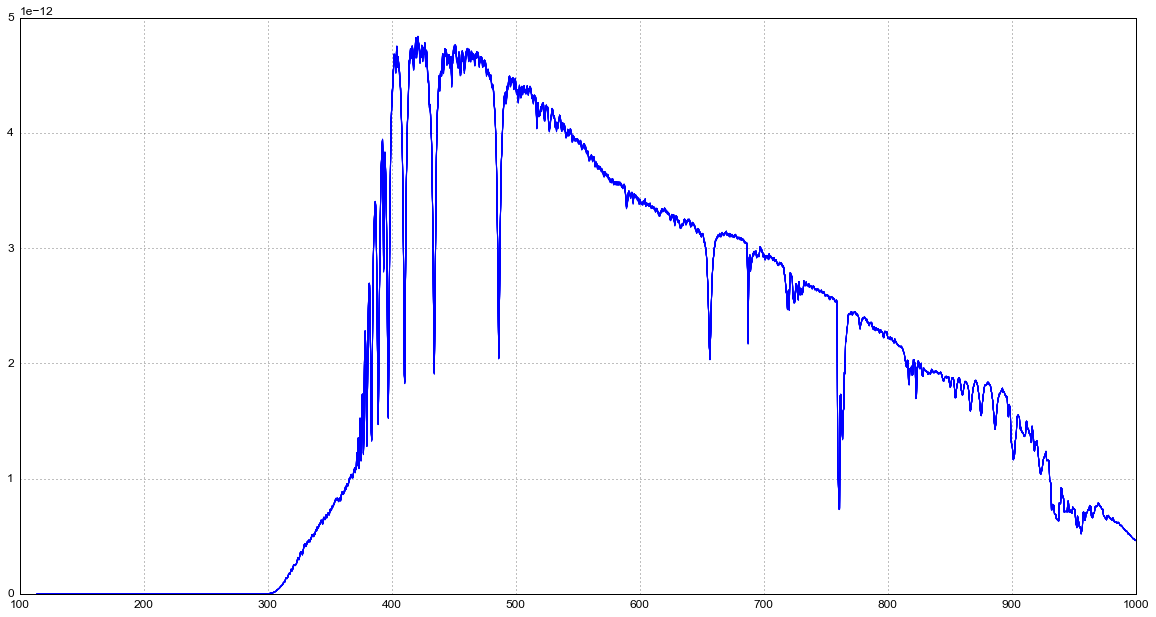

In [20]:
plt.figure(figsize=(20,10))

for idx,fileindex in np.ndenumerate(file_indexes):
    
    if fileindex != 102:
        basefile_atm=root_file+str(fileindex)+ext_file     # input file

        #print basefile_atm
    
        file_atm=os.path.join(path_atm,basefile_atm)

        atm_array=np.loadtxt(file_atm)
        wavelength_atm=atm_array[:,0] # in nm
        transmission_atm=atm_array[:,1]
    
        selected_wlindexes=np.where(np.logical_and(wavelength_atm>=0, wavelength_atm<1000.))
        wavelength_atm=wavelength_atm[selected_wlindexes]
        transmission_atm=transmission_atm[selected_wlindexes]
    
        TATM=np.interp(wavelength_sed,wavelength_atm,transmission_atm)
    
        SED1=flux_sed
        SED2=flux_sed*TCCD
        SED3=flux_sed*TCCD*TATM
        SED4=flux_sed*TCCD*TATM*TOPT
        #save the file

        tablefitsfile='SEDPred_'+obj_name+'_'+night_name+'_'+str(fileindex)+'.fits'  # output file
    
        prim_hdr=fits.Header()
        prim_hdr['OBJ_NAME']=obj_name
        prim_hdr['UNITS']='wavelength in nm'
        prim_hdr['COMMENT']="Prediction of observable SED"
        primhdu=fits.PrimaryHDU(header=prim_hdr)
    
        col1 = fits.Column(name='WAVELENGTH', format='E', array=wavelength_sed)
        col2 = fits.Column(name='SEDcalspec', format='E', array=SED1)
        col3 = fits.Column(name='SEDxQE', format='E', array=SED2)
        col4 = fits.Column(name='SEDxQExATM', format='E', array=SED3)
        col5 = fits.Column(name='SEDxQExATMxTopt', format='E', array=SED4)
    
        cols = fits.ColDefs([col1, col2,col3,col4,col5])     # definition of the column
        tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    
        thdulist = fits.HDUList([primhdu, tbhdu])
        thdulist.writeto(tablefitsfile,clobber=True)
        
        plt.plot(wavelength_sed,SED4,color='b')
        
        